In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier, StackingClassifier
from sklearn.svm import SVC 
from catboost import CatBoostClassifier
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate,cross_val_predict
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df_pre = pd.read_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/1_thyroid_pre.csv')
df_pre_sel = pd.read_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/2_thyroid_pre_sel.csv')
df_syn = pd.read_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/3_thyroid_syn.csv')
df_syn_sel = pd.read_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/4_thyroid_syn_sel.csv')

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    #"CatBoost": CatBoostClassifier(random_state=42, verbose=0)    
}

# Model Training

# Train-Test_split

In [21]:
datasets = {
    "Preprocessed (All Features)": df_pre,
    "Preprocessed (Selected Features)": df_pre_sel,
    "SMOTE Balanced (All Features)": df_syn,
    "SMOTE Balanced (Selected Features)": df_syn_sel
}

In [7]:
def evaluate_models(df, dataset_name):
    X = df.drop("target", axis=1)
    y = df["target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    results = []
    for model_name, model in models.items():
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1 Score": f1_score(y_test, y_pred, zero_division=0),
            "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
        })

    return results

In [8]:
all_results = []
for name, df in datasets.items():
    all_results.extend(evaluate_models(df, name))
results_df = pd.DataFrame(all_results)

In [9]:
results_df

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Preprocessed (All Features),Logistic Regression,0.800545,0.787879,0.325000,0.460177,0.783671
1,Preprocessed (All Features),Random Forest,0.938965,0.889831,0.875000,0.882353,0.971035
2,Preprocessed (All Features),XGBoost,0.942779,0.894737,0.885417,0.890052,0.980958
3,Preprocessed (All Features),SVM,0.805995,0.897436,0.291667,0.440252,0.842750
4,Preprocessed (All Features),CatBoost,0.949864,0.909283,0.897917,0.903564,0.983700
5,Preprocessed (Selected Features),Logistic Regression,0.798910,0.806630,0.304167,0.441755,0.778378
6,Preprocessed (Selected Features),Random Forest,0.934605,0.871901,0.879167,0.875519,0.969126
7,Preprocessed (Selected Features),XGBoost,0.935695,0.878661,0.875000,0.876827,0.973130
8,Preprocessed (Selected Features),SVM,0.821253,0.848624,0.385417,0.530086,0.856015
9,Preprocessed (Selected Features),CatBoost,0.942234,0.896186,0.881250,0.888655,0.979037


In [10]:
results_df.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_TTS_Results.csv', index=False)

### K-Fold

In [5]:
datasets_kfold = {
    "Preprocessed (All Features)": (df_pre.drop("target", axis=1), df_pre["target"]),
    "Preprocessed (Selected Features)": (df_pre_sel.drop("target", axis=1), df_pre_sel["target"]),
    "SMOTE Balanced (All Features)": (df_syn.drop("target", axis=1), df_syn["target"]),
    "SMOTE Balanced (Selected Features)": (df_syn_sel.drop("target", axis=1), df_syn_sel["target"])
}

In [7]:
def evaluate_kfold(X, y, model, model_name, dataset_name, k=10):
    """
    Perform Stratified K-Fold cross-validation and return aggregated metrics.
    """
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        if y_proba is not None:
            aucs.append(roc_auc_score(y_test, y_proba))
    return {
        "Dataset": dataset_name,
        "Model": model_name,
        "Accuracy": f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}",
        "Precision": f"{np.mean(precisions):.3f} ± {np.std(precisions):.3f}",
        "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
        "F1 Score": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}",
        "ROC-AUC": f"{np.mean(aucs):.3f} ± {np.std(aucs):.3f}" if aucs else "N/A"
    }

In [8]:
all_kfold_results = []

In [9]:
for dataset_name, (X, y) in datasets_kfold.items():
    for model_name, model in models.items():  
        result = evaluate_kfold(X, y, model, model_name, dataset_name, k=10)
        all_kfold_results.append(result)

In [10]:
results_kfold_df = pd.DataFrame(all_kfold_results)

In [11]:
results_kfold_df

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Preprocessed (All Features),Logistic Regression,0.799 ± 0.009,0.765 ± 0.038,0.336 ± 0.028,0.466 ± 0.030,0.777 ± 0.021
1,Preprocessed (All Features),Random Forest,0.939 ± 0.005,0.909 ± 0.014,0.851 ± 0.019,0.879 ± 0.011,0.973 ± 0.008
2,Preprocessed (All Features),XGBoost,0.945 ± 0.006,0.916 ± 0.017,0.871 ± 0.024,0.892 ± 0.013,0.982 ± 0.005
3,Preprocessed (All Features),CatBoost,0.949 ± 0.008,0.924 ± 0.012,0.876 ± 0.026,0.899 ± 0.016,0.984 ± 0.004
4,Preprocessed (Selected Features),Logistic Regression,0.796 ± 0.008,0.763 ± 0.037,0.319 ± 0.026,0.449 ± 0.027,0.768 ± 0.022
5,Preprocessed (Selected Features),Random Forest,0.934 ± 0.006,0.878 ± 0.018,0.869 ± 0.021,0.873 ± 0.012,0.972 ± 0.007
6,Preprocessed (Selected Features),XGBoost,0.934 ± 0.008,0.888 ± 0.024,0.855 ± 0.026,0.871 ± 0.016,0.976 ± 0.005
7,Preprocessed (Selected Features),CatBoost,0.940 ± 0.008,0.900 ± 0.020,0.870 ± 0.030,0.884 ± 0.017,0.979 ± 0.005
8,SMOTE Balanced (All Features),Logistic Regression,0.688 ± 0.009,0.721 ± 0.011,0.619 ± 0.015,0.666 ± 0.011,0.754 ± 0.012
9,SMOTE Balanced (All Features),Random Forest,0.916 ± 0.007,0.923 ± 0.010,0.909 ± 0.012,0.916 ± 0.007,0.974 ± 0.004


In [12]:
results_kfold_df.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_K-Fold_Results.csv', index=False)

### 100EXEC TTS

In [6]:
def prepare_target(series: pd.Series) -> pd.Series:
    """Ensure Attrition is binary 0/1 regardless of Yes/No or already numeric."""
    if series.dtype == "O":  # object/string → Yes/No
        return series.map({"Yes": 1, "No": 0})
    return series.astype(int)

In [7]:
datasets = {
    "Preprocessed (All Features)": (
        df_pre.drop(columns=["target"]),
        prepare_target(df_pre["target"])
    ),
    "Preprocessed (Selected Features)": (
        df_pre_sel.drop(columns=["target"]),
        prepare_target(df_pre_sel["target"])
    ),
    "SMOTE Balanced (All Features)": (
        df_syn.drop(columns=["target"]),
        prepare_target(df_syn["target"])
    ),
    "SMOTE Balanced (Selected Features)": (
        df_syn_sel.drop(columns=["target"]),
        prepare_target(df_syn_sel["target"])
    )
}

In [10]:
def evaluate_repeated_exec(X, y, model, model_name, dataset_name, n_exec=100, test_size=0.2):
   
    accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []
    exec_results = []
    for run in range(1, n_exec + 1):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=run
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            try:
                y_proba = model.decision_function(X_test)
            except:
                y_proba = None
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        aucs.append(auc)
        # Store run-level results
        exec_results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Run": run,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "ROC-AUC": auc
        })
    # Summary statistics
    summary = {
        "Dataset": dataset_name,
        "Model": model_name,
        "Accuracy": f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}",
        "Precision": f"{np.mean(precisions):.3f} ± {np.std(precisions):.3f}",
        "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
        "F1 Score": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}",
        "ROC-AUC": f"{np.nanmean(aucs):.3f} ± {np.nanstd(aucs):.3f}" if not np.all(np.isnan(aucs)) else "N/A"
    }
    return summary, exec_results

In [11]:
all_exec_summaries = []
all_exec_raw = []
for dataset_name, (X, y) in datasets.items():
    for model_name, model in models.items():
        print(f"[INFO] Running {model_name} on {dataset_name} with 100 executions ...")
        summary, runs = evaluate_repeated_exec(X, y, model, model_name, dataset_name, n_exec=100)
        all_exec_summaries.append(summary)
        all_exec_raw.extend(runs)

[INFO] Running Logistic Regression on Preprocessed (All Features) with 100 executions ...
[INFO] Running Random Forest on Preprocessed (All Features) with 100 executions ...
[INFO] Running XGBoost on Preprocessed (All Features) with 100 executions ...
[INFO] Running Logistic Regression on Preprocessed (Selected Features) with 100 executions ...
[INFO] Running Random Forest on Preprocessed (Selected Features) with 100 executions ...
[INFO] Running XGBoost on Preprocessed (Selected Features) with 100 executions ...
[INFO] Running Logistic Regression on SMOTE Balanced (All Features) with 100 executions ...
[INFO] Running Random Forest on SMOTE Balanced (All Features) with 100 executions ...
[INFO] Running XGBoost on SMOTE Balanced (All Features) with 100 executions ...
[INFO] Running Logistic Regression on SMOTE Balanced (Selected Features) with 100 executions ...
[INFO] Running Random Forest on SMOTE Balanced (Selected Features) with 100 executions ...
[INFO] Running XGBoost on SMOTE Bal

In [12]:
df_exec_summary = pd.DataFrame(all_exec_summaries)
df_exec_raw = pd.DataFrame(all_exec_raw)

In [13]:
df_exec_summary

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Preprocessed (All Features),Logistic Regression,0.799 ± 0.006,0.764 ± 0.028,0.334 ± 0.020,0.464 ± 0.020,0.774 ± 0.010
1,Preprocessed (All Features),Random Forest,0.937 ± 0.005,0.901 ± 0.013,0.851 ± 0.016,0.875 ± 0.010,0.972 ± 0.004
2,Preprocessed (All Features),XGBoost,0.944 ± 0.005,0.911 ± 0.012,0.871 ± 0.014,0.890 ± 0.009,0.981 ± 0.003
3,Preprocessed (Selected Features),Logistic Regression,0.796 ± 0.006,0.766 ± 0.030,0.318 ± 0.020,0.449 ± 0.021,0.765 ± 0.011
4,Preprocessed (Selected Features),Random Forest,0.932 ± 0.005,0.873 ± 0.013,0.865 ± 0.015,0.869 ± 0.011,0.971 ± 0.004
5,Preprocessed (Selected Features),XGBoost,0.934 ± 0.005,0.885 ± 0.013,0.858 ± 0.015,0.871 ± 0.010,0.976 ± 0.003
6,SMOTE Balanced (All Features),Logistic Regression,0.684 ± 0.007,0.717 ± 0.009,0.615 ± 0.013,0.662 ± 0.009,0.751 ± 0.008
7,SMOTE Balanced (All Features),Random Forest,0.913 ± 0.005,0.919 ± 0.006,0.907 ± 0.008,0.913 ± 0.005,0.972 ± 0.003
8,SMOTE Balanced (All Features),XGBoost,0.924 ± 0.005,0.927 ± 0.006,0.921 ± 0.008,0.924 ± 0.005,0.978 ± 0.002
9,SMOTE Balanced (Selected Features),Logistic Regression,0.684 ± 0.007,0.717 ± 0.009,0.615 ± 0.013,0.662 ± 0.009,0.751 ± 0.008


In [14]:
df_exec_summary.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_100Exex_tts_Results.csv', index=False)
df_exec_raw.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_ALL100Exec_tts_Results.csv', index=False)

### Ensemble Method Using K-Fold

In [15]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

In [16]:
# Ensembles
voting_hard = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
    voting='hard'
)

voting_soft = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
    voting='soft'
)

stacking = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
    final_estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
    cv=10
)

In [17]:
# Models dict
ensemble_models = {
    "Voting (Hard)": voting_hard,
    "Voting (Soft)": voting_soft,
    "Stacking": stacking
}

In [18]:
# Evaluation function
def evaluate_ensembles(datasets, models, target_col="target"):
    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for ds_name, df in datasets.items():
        X = df.drop(columns=[target_col])
        y = df[target_col]

        for model_name, model in models.items():
            # If it's hard voting → no ROC-AUC
            if "Voting (Hard)" in model_name:
                scoring_used = ['accuracy', 'precision', 'recall', 'f1']
            else:
                scoring_used = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

            cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring_used, n_jobs=-1)

            # Build results dictionary dynamically
            result = {
                "Dataset": ds_name,
                "Model": model_name,
                "Accuracy": f"{np.mean(cv_results['test_accuracy']):.3f} ± {np.std(cv_results['test_accuracy']):.3f}",
                "Precision": f"{np.mean(cv_results['test_precision']):.3f} ± {np.std(cv_results['test_precision']):.3f}",
                "Recall": f"{np.mean(cv_results['test_recall']):.3f} ± {np.std(cv_results['test_recall']):.3f}",
                "F1 Score": f"{np.mean(cv_results['test_f1']):.3f} ± {np.std(cv_results['test_f1']):.3f}"
            }

            # Only add ROC-AUC if available
            if "roc_auc" in scoring_used:
                result["ROC-AUC"] = f"{np.mean(cv_results['test_roc_auc']):.3f} ± {np.std(cv_results['test_roc_auc']):.3f}"

            results.append(result)

    return pd.DataFrame(results)


In [22]:
df_ensemble_results = evaluate_ensembles(datasets, ensemble_models, target_col="target")

In [23]:
df_ensemble_results

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Preprocessed (All Features),Voting (Hard),0.947 ± 0.005,0.921 ± 0.005,0.871 ± 0.018,0.895 ± 0.010,NaN
1,Preprocessed (All Features),Voting (Soft),0.947 ± 0.003,0.922 ± 0.008,0.872 ± 0.017,0.896 ± 0.008,0.982 ± 0.003
2,Preprocessed (All Features),Stacking,0.949 ± 0.004,0.928 ± 0.006,0.872 ± 0.019,0.899 ± 0.009,0.983 ± 0.002
3,Preprocessed (Selected Features),Voting (Hard),0.939 ± 0.005,0.891 ± 0.003,0.871 ± 0.023,0.881 ± 0.011,NaN
4,Preprocessed (Selected Features),Voting (Soft),0.939 ± 0.005,0.893 ± 0.005,0.872 ± 0.022,0.882 ± 0.010,0.978 ± 0.003
5,Preprocessed (Selected Features),Stacking,0.939 ± 0.005,0.899 ± 0.005,0.865 ± 0.021,0.882 ± 0.011,0.978 ± 0.003
6,SMOTE Balanced (All Features),Voting (Hard),0.926 ± 0.002,0.932 ± 0.005,0.919 ± 0.004,0.925 ± 0.002,NaN
7,SMOTE Balanced (All Features),Voting (Soft),0.927 ± 0.002,0.933 ± 0.005,0.921 ± 0.004,0.927 ± 0.002,0.981 ± 0.001
8,SMOTE Balanced (All Features),Stacking,0.929 ± 0.002,0.930 ± 0.005,0.929 ± 0.002,0.930 ± 0.002,0.981 ± 0.001
9,SMOTE Balanced (Selected Features),Voting (Hard),0.926 ± 0.002,0.932 ± 0.005,0.919 ± 0.004,0.925 ± 0.002,NaN


In [24]:
df_ensemble_results.to_csv('D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/df_ensemble_Results.csv', index=False)

### Downloading Best Model

In [26]:
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42)),
    ('cat' , CatBoostClassifier(verbose=0, random_state=42))
]
meta_learner = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=10,
    n_jobs=-1
)
X = df_syn.drop(columns=["target"])
y = df_syn["target"]
stacking_model.fit(X, y)

StackingClassifier(cv=10,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weig...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x0000019A4B3F3E90>)],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='liblinear'),
                   n_jobs=-1)

In [27]:
y_pred = stacking_model.predict(X)

### Performance Evaluation

In [30]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred_oof = cross_val_predict(stacking_model, X, y, cv=cv, method='predict', n_jobs=-1)
y_proba_oof = cross_val_predict(stacking_model, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

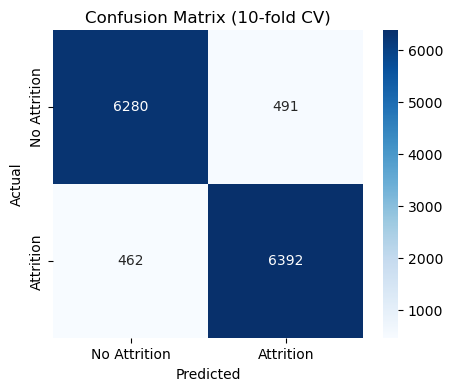

In [31]:
cm = confusion_matrix(y, y_pred_oof)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Attrition", "Attrition"],
            yticklabels=["No Attrition", "Attrition"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (10-fold CV)")
plt.show()

In [32]:
print("Classification Report (10-fold CV):\n")
print(classification_report(y, y_pred_oof, target_names=["No Attrition", "Attrition"]))

Classification Report (10-fold CV):

              precision    recall  f1-score   support

No Attrition       0.93      0.93      0.93      6771
   Attrition       0.93      0.93      0.93      6854

    accuracy                           0.93     13625
   macro avg       0.93      0.93      0.93     13625
weighted avg       0.93      0.93      0.93     13625



ROC-AUC (10-fold CV): 0.9817


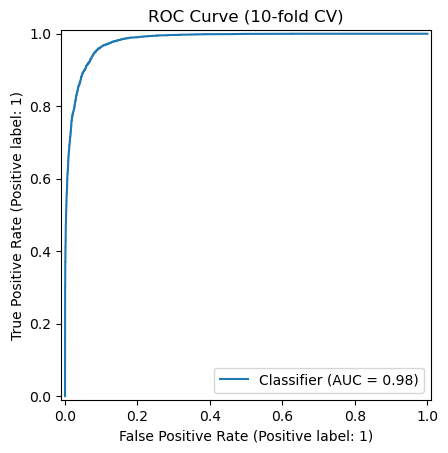

In [33]:
auc = roc_auc_score(y, y_proba_oof)
print(f"ROC-AUC (10-fold CV): {auc:.4f}")

RocCurveDisplay.from_predictions(y, y_proba_oof)
plt.title("ROC Curve (10-fold CV)")
plt.show()

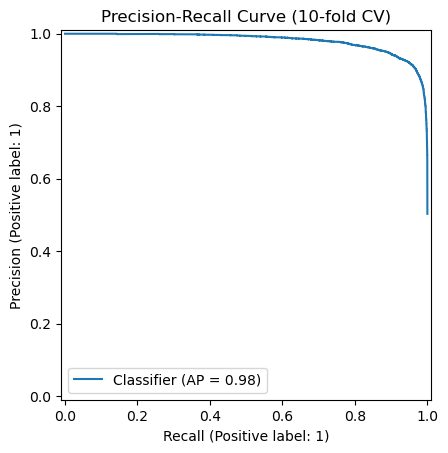

In [34]:
PrecisionRecallDisplay.from_predictions(y, y_proba_oof)
plt.title("Precision-Recall Curve (10-fold CV)")
plt.show()

In [29]:
joblib.dump(stacking_model, "D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/stacking_attrition_model.pkl")

['D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/stacking_attrition_model.pkl']

### Model Deployment

In [ ]:
import joblib
import numpy as np
import pandas as pd
from flask import Flask, render_template, request
from pyngrok import ngrok

# === Load Saved Model & Scaler ===
# === Load Saved Model, Scaler & Encoder ===
model = joblib.load("D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/stacking_attrition_model.pkl")
scaler = joblib.load("D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/minmax_scaler_1.pkl")

# === Flask App ===
app = Flask(
    __name__,
    template_folder="D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/Templates",
    static_folder="D:/Machine Learning Projects/4. Predictive Modeling for Thyroid Disease Diagnosis/Templates/static"
)
# === Features in Exact Order ===
FEATURES = [
    "age", "sex", "on_thyroxine", "query_on_thyroxine", "on_antithyroid_meds",
    "sick", "pregnant", "thyroid_surgery", "I131_treatment", "query_hypothyroid",
    "query_hyperthyroid", "goitre", "tumor", "psych", "TSH", "T3", "TT4", "T4U", "FTI"
]

@app.route("/")
def index():
    return render_template("index.html")

@app.route("/predict", methods=["POST"])
def predict():
    try:
        # Collect inputs
        data = []
        for feature in FEATURES:
            val = request.form.get(feature)

            # Handle special conversions
            if feature == "sex":
                val = 1 if val.lower() == "m" else 0  # m=1, f=0
            elif feature in ["age", "TSH", "T3", "TT4", "T4U", "FTI"]:
                val = float(val)  # continuous
            else:
                val = 1 if val.lower() in ["yes", "1"] else 0  # binary yes/no

            data.append(val)

        # Convert to DataFrame
        input_df = pd.DataFrame([data], columns=FEATURES)

        # Scale only continuous (non-binary) features
        numeric_features = ["age", "TSH", "T3", "TT4", "T4U", "FTI"]
        input_df[numeric_features] = scaler.transform(input_df[numeric_features])

        # Predict
        prediction = model.predict(input_df)[0]
        probability = model.predict_proba(input_df)[0][1]

        result = "Thyroid Disease Detected" if prediction == 1 else "No Thyroid Disease"

        return render_template("result.html", result=result, probability=round(probability, 4))

    except Exception as e:
        return render_template("result.html", result="Error: " + str(e), probability="N/A")

if __name__ == "__main__":
    # Expose via ngrok
    public_url = ngrok.connect(5000)
    print(" * ngrok tunnel URL:", public_url)
    app.run(port=5000)


 * ngrok tunnel URL: NgrokTunnel: "https://c3f96a83e30c.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [01/Sep/2025 02:44:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2025 02:44:26] "GET /static/script.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2025 02:44:26] "GET /static/style.css HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2025 02:44:27] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [01/Sep/2025 02:45:44] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2025 02:45:45] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Sep/2025 02:45:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Sep/2025 02:45:53] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Sep/2025 02:45:54] "GET /static/script.js HTTP/1.1" 304 -
